In [74]:
import os
import gc
import glob

from multiprocessing import Pool
from functools import partial
import numpy as np

import math 

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs

from sklearn.metrics import accuracy_score
import sklearn

from SmilesPE.pretokenizer import atomwise_tokenizer
from SmilesPE.pretokenizer import kmer_tokenizer

import string
import tqdm
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device,torch.cuda.is_available()

(device(type='cuda'), True)

In [75]:
trial = True # setting False saves the output files else not saved

In [76]:
### Output log file
if not trial:
    try:
        os.system("mkdir output_files")
    except:
        print ("Folder output_files already present")

    present_files = glob.glob("output_files/log_output_*.txt")
    log_file_name = "output_files/log_output_" + str(len(present_files) + 1) + ".txt"
    log_file = open(log_file_name,"w",1)

### Parameters

In [77]:
multi_files = True

if multi_files:
    input_file = ["first_5000.txt","ML_input_5338.txt"]
else:
    input_file = "first_5000.txt" # Input data containing smiles and label

number_of_augmentation = 1 # Data augmentation multiplier
train_percentage = 0.9 # Fraction to use for training (valida and test would be half of remaining data)
Number_of_workers = 8 # Number of CPU threads to use

#### Remove rdkit warnings (optional)

In [78]:
# To remove rdkit warning
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [79]:
# Convert to fingerprint

def smiles_fingerprint(smiles,ftype,radius=None,bits=2048):
    m1 = Chem.MolFromSmiles(smiles)
    if ftype == "morgan":
        fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,radius,nBits=bits)
        
    if ftype == "topological":
        fp1 = Chem.RDKFingerprint(m1)
        
    if ftype == "MACCS":
        fp1 = MACCSkeys.GenMACCSKeys(m1)
        
    if ftype == "atompairs":
        fp1 = Pairs.GetAtomPairFingerprint(m1)
        
    bits = fp1.ToBitString()
    return (bits)

In [80]:
# Handling smiles format

def to_canonical_smiles(molecule):
    try:
        canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(molecule))
    except:
        canonical_smile = False
    return canonical_smile

def get_cluster_count(y_count):
    cluster_count = {}
    for y in y_count:
        if y not in cluster_count:
            cluster_count[y] = 1
        else:
            cluster_count[y] +=1
    return (cluster_count)

def randomize_smiles(smiles,random_smiles=[],iteration=5):
    try:
        m = Chem.MolFromSmiles(smiles)
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m,ans)
        out_smiles = (Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True, kekuleSmiles=False))
    except:
        return (False)
    
    if out_smiles not in random_smiles:
        return out_smiles
    else:
        iteration -= 1
        if iteration > 0:
            out_smiles = randomize_smiles(smiles,random_smiles,iteration)
            return out_smiles
        return (False)
    
def augment_smiles(count,iteration,smiles):
    random_smiles = []
    for i in range(count):
        if smiles != None:
            out_smiles = randomize_smiles(smiles,random_smiles,iteration=iteration)
            if out_smiles:
                random_smiles.append(out_smiles)
            else:
                break
        
    return random_smiles

def unpack_and_write_list(smiles,label,filename):
    for entry in smiles:
        if type(entry) == list:
            unpack_and_write_list(entry,label,filename)
        else:
            filename.write(entry + "," + str(label) + "\n")
    
def smiles_augmentation(df, N_rounds=1,iteration=5,data_set_type="train"):
    
    try:
        os.mkdir("data")
        os.mkdir("data/classification")
    except:
        pass
    
    filename = "data/classification/" + str(data_set_type) + "_aug_canonical_smiles.csv"

    aug_out = open(filename,"w")

    aug_out.write("Smiles,Label\n")
        
    labels = []
    for label in df.groupby('Label'):
        labels.append(label[0])
    
    augmentation_list = []
    if type(N_rounds) == list:
        assert(len(N_rounds) == len(labels))
        augmentation_list = N_rounds
    else:
        for i in range(len(labels)):
            augmentation_list.append(N_rounds)
        
    for label,augmentation in zip(labels,augmentation_list):
    
        canonical_smiles = df[df['Label'] == label]['Smiles'].to_list()

        p = Pool(Number_of_workers)
        func = partial(augment_smiles, augmentation, iteration)
        augmented_smiles = list(tqdm.tqdm(p.imap(func, canonical_smiles), total=len(canonical_smiles),leave=False))
        p.close()
    
        print ("Saving data for label = " + str(label))

        unpack_and_write_list(augmented_smiles,label,filename=aug_out)

        unpack_and_write_list(canonical_smiles,label,filename=aug_out)
        
        print ("Saved data for label = " + str(label))
        
    aug_out.close()
    
    return (pd.read_csv(filename, header=0).sample(frac=1).reset_index(drop=True))
    


In [81]:
if multi_files:
    for i,input_filename in enumerate(input_file):
        if i != 0:
            quantmap_data2 = pd.read_csv(input_filename,sep=" ",names=["Smiles", "Label"]).sample(frac=1).reset_index(drop=True) #,header=None)
            quantmap_data = pd.concat([quantmap_data,quantmap_data2])
        else:
            quantmap_data = pd.read_csv(input_filename,sep=" ",names=["Smiles", "Label"]).sample(frac=1).reset_index(drop=True) #,header=None)
    del quantmap_data2
else:
    quantmap_data = pd.read_csv(input_file,sep=" ",names=["Smiles", "Label"]).sample(frac=1).reset_index(drop=True)

    
print('Dataset:', quantmap_data.shape)
quantmap_data.head(5)

Dataset: (9854, 2)


,Smiles,Label
0,C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3O)O)O,1
1,C(C(=O)[O-])F,1
2,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])F,0
3,[N+](=O)(O)[O-].[N+](=O)(O)[O-].[N+](=O)(O)[O-...,1
4,CC1=CC(=NC(=O)N1)C.C1=CC(=CC=C1NC(=O)NC2=CC=C(...,1


In [82]:
print (quantmap_data.groupby('Label').count())
if not trial:
    log_file.write("Class distribution before augmentation\n")
    log_file.write(str(quantmap_data.groupby('Label').count()) + "\n")
    

       Smiles
Label        
0        1919
1        4662
2        2508
3         390
4         375


In [83]:
label_count_df = quantmap_data.groupby('Label').count()
label_count_list = []
for entry in range(len(label_count_df)):
    label_count_list.append(label_count_df.iloc[entry][0])

augmentation_list = []
max_value = max(label_count_list)
for entry in label_count_list:
    value = max_value/entry
    if value % 1 > 0.5:
        value = math.ceil(value)
    else:
        value = math.floor(value)
    augmentation_list.append(value)

In [84]:
###
augmentation_list = [entry*number_of_augmentation for entry in augmentation_list]
iteration = 1000000
# Augmentation for training data
quantmap_data = smiles_augmentation(quantmap_data,N_rounds=augmentation_list,iteration=iteration,data_set_type="all_data")

Saving data for label = 0
Saved data for label = 0


Saving data for label = 1
Saved data for label = 1


Saving data for label = 2
Saved data for label = 2


Saving data for label = 3
Saved data for label = 3


Saving data for label = 4
Saved data for label = 4


In [85]:
print (quantmap_data.groupby('Label').count())
if not trial:
    log_file.write("number of augmentation = " + str(number_of_augmentation) + "\n")
    log_file.write("Class distribution after augmentation\n")
    log_file.write(str(quantmap_data.groupby('Label').count()) + "\n")
    log_file.write("Train/valid split ratio = " + str(train_percentage) + "\n")
    

       Smiles
Label        
0        5749
1        9323
2        7514
3        4936
4        4680


### Data preparation

In [86]:
output_label = "None" #"fingerprint"
class MolTokenizer():
    def __init__(self, lang = 'en'):
        self.lang = lang
        
    def tokenizer(self, output_label=None,smiles=None):
        tokens = atomwise_tokenizer(smiles)
        tokens.insert(0, "<SOS>") 
        tokens.append("<EOS>")
        if output_label != "fingerprint":
            return tokens
        else:
            try:
                fingerprint = smiles_fingerprint(smiles,"morgan", radius=2,bits=1024)
                return tokens,fingerprint
            except:
                return None,None
        
    def add_special_cases(self, toks):
        pass

tok = MolTokenizer()

In [87]:
# To make vocabulary

def unpack_vocab_list(vocab_list,vocab_unpacked):
    for entry in vocab_list:
        if type(entry) == list:
            unpack_vocab_list(entry,vocab_unpacked)
        else:
            vocab_unpacked.append(entry)
            
    return (vocab_unpacked)
            
def make_vocabulary(input_list):
    p = Pool(Number_of_workers)
    func = partial(tok.tokenizer, None)
    vocab_list = list(tqdm.tqdm(p.imap(func, input_list), total=len(input_list),leave=False))
    p.close()
    vocab_unpacked = []
    return (list(set(unpack_vocab_list(vocab_list,vocab_unpacked))))

def make_word_index(vocab):
    word_index = {}
    index_word = {}
    for i,entry in enumerate(vocab):
        word_index[entry] = i
        index_word[i] = entry
    return (word_index,index_word)

In [90]:
use_vocab_file = True

if use_vocab_file:
    en_vocab = open("en_vocab_153.txt","r").read().strip("[]").replace("'", "").replace(" ", "").split(",")
    en_word_index,en_index_word = make_word_index(en_vocab)
    
else:
    all_smiles = quantmap_data["Smiles"].to_list()

    en_vocab = ["<PAD>","<UNK>"]
    en_vocab.extend(make_vocabulary(all_smiles))
    del all_smiles

    ###
    en_word_index,en_index_word = make_word_index(en_vocab)

    vocab_output = open("en_vocab_.txt","w")
    vocab_output.write(str(en_vocab))
    vocab_output.close()

In [91]:
len(en_vocab)

153

In [92]:
############### DECODER EMBEDDING REQUIREMENT


de_word_index,de_index_word,de_vocab = en_word_index,en_index_word,en_vocab

In [93]:
def convert_smiles_to_tokens(df):
    
    if output_label != "fingerprint": # Maintain the y from the data as label
        labels = []
        for label in df.groupby('Label'):
            labels.append(label[0])

        x = []
        y = []
        p = Pool(Number_of_workers)
        for label in labels:
            smiles_list = df[df['Label'] == label]['Smiles'].to_list()
            
            
            func = partial(tok.tokenizer, None)
            tokens = list(tqdm.tqdm(p.imap(func, smiles_list), total=len(smiles_list),leave=False))
            
            #p = Pool(Number_of_workers)
            #tokens = list(tqdm.tqdm(p.imap(tok.tokenizer, smiles_list), total=len(smiles_list),leave=False))
            #p.close()
            #if len(tokens) < 100:
            for entry in tokens:
                if  5 < len(entry) <= 150:
                #break
                    x.append(entry)
                    y.append([label for i in range(len(entry))])
            #x.extend(tokens)
            #y.extend([label for i in range(len(tokens))])
        p.close()
            
    else: # Return fingerprint as label for each object
        x = []
        y = []
        smiles_list = df['Smiles'].to_list()
        
        func = partial(tok.tokenizer, output_label)
        
        for entry in smiles_list:
            xout,yout = (func(entry))
            if xout != None:
                x.append(xout)
                y.append([int(entry) for entry in yout])
        
        print (str(len(smiles_list)-len(x)) + " incorrect smiles detected and deleted"  )
        
    return (x,y)

In [94]:
x,y = convert_smiles_to_tokens(quantmap_data)

In [95]:
lenthwise_x = [len(entry) for entry in x if len(entry)]

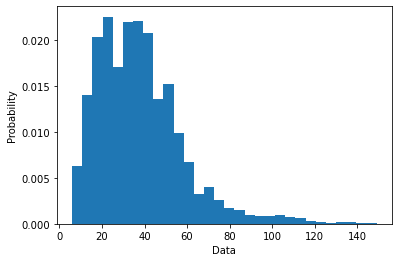

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(lenthwise_x, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [97]:
def convert_token_to_index(molecule):
    idxs = []
    for ch in molecule:
        if ch in en_word_index:
            idxs.append(en_word_index[ch])
        else:
            idxs.append(en_word_index["<UNK>"])
    return torch.tensor(idxs)

In [98]:
def convert_index_to_onehot(molecule):
    idxs = [word_index[ch] for ch in molecule]
    string_vector = []
    for idx in idxs:
        y_onehot = np.zeros((1,len(en_word_index)))
        y_onehot[np.arange(1),idx] = 1
        string_vector.append(y_onehot[0])
    return torch.tensor(string_vector)

#x_onehot = []
#loop = tqdm.tqdm(x, total=len(x),leave=False)
#for entry in loop:
#    x_onehot.append(convert_to_onehot(entry))

In [99]:
x_indexed_token = []
loop = tqdm.tqdm(x, total=len(x),leave=False)
for entry in loop:
    x_indexed_token.append(convert_token_to_index(entry))

### Shuffling data

In [100]:
valid_test_percentage = (1 - train_percentage)/2

data_to_use = quantmap_data
# Ratios
train_ratio = int (len(data_to_use) * train_percentage)
valid_ratio = train_ratio + int(len(data_to_use)*valid_test_percentage)
test_ratio = valid_ratio + int(len(data_to_use)*valid_test_percentage)

In [101]:
# Make index to split into train and val set
def make_index(len_data,train_ratio,valid_ratio,test_ratio):
    
    index = np.random.permutation(len_data)
    
    # Train index and val index
    return (index[:train_ratio],index[train_ratio:valid_ratio],index[valid_ratio:test_ratio])

train_index ,valid_index,test_index = make_index(len(data_to_use),train_ratio,valid_ratio,test_ratio)

### Dataloaders by padding the tokens

In [102]:
from torch.utils.data import Dataset, TensorDataset, SubsetRandomSampler

In [103]:

x_padded = pad_sequence(x_indexed_token,batch_first=True, padding_value=0)

train_sample = SubsetRandomSampler(train_index)
valid_sample = SubsetRandomSampler(valid_index)
test_sample = SubsetRandomSampler(test_index)
batch_size = 64


#dataset = torch.utils.data.TensorDataset(x_padded, torch.tensor(y))
dataset = torch.utils.data.TensorDataset(x_padded, x_padded)

train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size,
                                        sampler=train_sample)

valid_loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                        sampler=valid_sample)

test_loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                        sampler=test_sample)

### Data without padding

In [104]:
train_data = [(entry,entry) for i,entry in enumerate(x_indexed_token) if i in train_index]
valid_data = [(entry,entry) for i,entry in enumerate(x_indexed_token) if i in valid_index]
test_data = [(entry,entry) for i,entry in enumerate(x_indexed_token) if i in test_index]

### Bucket iterator

In [105]:
class MakeDataset(Dataset):
    """PyTorch Dataset class for loading data.
      This is where the data parsing happens.
      This class is built with reusability in mind.
      Arguments:
      path (:obj:`str`):
      Path to the data partition.
      """
    
    def __init__(self, data_tuple):

        # Check if path exists.
        #if not os.path.isdir(path):
          # Raise error if path is invalid.
          #raise ValueError('Invalid `path` variable! Needs to be a directory')
    
        self.texts = []
        self.labels = []
        # Since the labels are defined by folders with data we loop 
        # through each label.
        '''for label  in ['pos', 'neg']:
            sentiment_path = os.path.join(path, label)

            # Get all files from path.
            files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
            # Go through each file and read its content.
            for file_name in tqdm(files_names, desc=f'{label} Files'):
                file_path = os.path.join(sentiment_path, file_name)

                # Read content.
                content = io.open(file_path, mode='r', encoding='utf-8').read()
                # Fix any unicode issues.
                content = fix_text(content)
                # Save content.
                self.texts.append(content)
                # Save labels.
                self.labels.append(label)'''
        for entry in data_tuple:
            self.texts.append(entry[0])
            self.labels.append(entry[1])
        # Number of examples.
        self.n_examples = len(self.labels)
        return


    def __len__(self):
        """When used `len` return the number of examples."""
        return self.n_examples


    def __getitem__(self, item):
        """Given an index return an example from the position.
        Arguments:
          item (:obj:`int`):
              Index position to pick an example to return.
        Returns:
          :obj:`Dict[str, str]`: Dictionary of inputs that are used to feed 
          to a model.
        """
        return {'text':self.texts[item], 'label':self.labels[item]}

In [106]:
train_dataset = MakeDataset(train_data)
valid_dataset = MakeDataset(valid_data)
test_dataset = MakeDataset(test_data)

from torchtext import data

batch_size = 1

train_iterator = data.BucketIterator(
    train_dataset,
    sort = True,
    sort_within_batch=True,
    sort_key=lambda x: len(x['text']),
    batch_size = batch_size,
    device = device)

valid_iterator = data.BucketIterator(
    valid_dataset,
    sort = True,
    sort_within_batch=True,
    sort_key=lambda x: len(x['text']),
    batch_size = batch_size,
    device = device)

test_iterator = data.BucketIterator(
    test_dataset,
    sort = True,
    sort_within_batch=True,
    sort_key=lambda x: len(x['text']),
    batch_size = batch_size,
    device = device)

In [107]:
gc.collect()
torch.cuda.empty_cache()

### MODEL

In [108]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size) #,padding_idx=0)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p,batch_first=True)

    def forward(self, x):
        # x shape: (N,seq_length) where N is batch size
        
        embedding = self.dropout(self.embedding(x))
        # embedding shape: (N,seq_length, embedding_size)
        
        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (N,seq_length, hidden_size)

        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size) #,padding_idx=0)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        
        x = x.unsqueeze(0)
        
        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (1, N, hidden_size)
        
        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)
        
        return predictions, hidden, cell


In [109]:
hidden_size = 1024  # Needs to be the same for both RNN's

input_size_encoder = len(en_vocab)
en_embedding_size = 400
en_num_layers = 3
en_dropout = 0.4

encoder_net = Encoder(
    input_size_encoder, 
    en_embedding_size, 
    hidden_size, 
    en_num_layers, 
    en_dropout
).to(device)

input_size_decoder = len(de_vocab)
de_embedding_size = 400
de_num_layers = 3
de_dropout = 0.4

output_size = len(de_vocab)

decoder_net = Decoder(
    input_size_decoder,
    de_embedding_size,
    hidden_size,
    output_size,
    de_num_layers,
    de_dropout,
).to(device)

In [110]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        
        target_vocab_size = len(de_vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        #target = target.view(target_len,-1)
        x = target[:,0]
        
        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell = self.decoder(x, hidden, cell)
            
            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)
            
            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[:,t] if random.random() < teacher_force_ratio else best_guess
        return outputs

In [111]:
batched = False



def validate(val_dl):
    model.eval()
    total_loss = []
    accuracy = []
    
    with torch.no_grad():
        
        
        
        val_dl.create_batches()
        loop = tqdm.tqdm(enumerate(val_dl.batches), total=len(val_dl),leave=False)
        for i,batch in loop:
            batch_text = [example["text"] for example in batch]
            batch_label = [example["label"] for example in batch]
            x_padded = pad_sequence(batch_text,batch_first=True, padding_value=0)
            y_padded = pad_sequence(batch_label,batch_first=True, padding_value=0)
            xvalc = x_padded.to(device)
            yvalc = y_padded.to(device)
            
            '''loop = tqdm.tqdm(enumerate(val_dl), total=len(val_dl),leave=False)
            for i, (xval,yval) in loop:
            xval = xval.view(1,-1)
            yval = yval.view(1,-1)
            xvalc = xval.to(device)
            yvalc = yval.to(device)'''

            # Forward prop
            output_val = model(xvalc.long(),yvalc)

            # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
            # doesn't take input in that form. For example if we have MNIST we want to have
            # output to be: (N, 10) and targets just (N). Here we can view it in a similar
            # way that we have output_words * batch_size that we want to send in into
            # our cost function, so we need to do some reshaping. While we're at it
            # Let's also remove the start token while we're at it
            output_val = output_val[1:].reshape(-1, output_val.shape[2])

            yvalc = yvalc[:,1:].reshape(-1)
            #print (output_train.shape,ybc.shape)

            accuracy.append(get_accuracy(output_val,yvalc))

            loss_val = criterion(output_val, yvalc)
            #loss_val = criterion(output_val, yvalc)

            total_loss.append(loss_val.item())
            
            loop.set_postfix(loss = sum(total_loss)/(i+1),acc = sum(accuracy)/(len(accuracy)))
    return (sum(total_loss)/(i+1),sum(accuracy)/(len(accuracy)))


def get_accuracy(yhat,y): #  FOR BCE ERROR
    
    if batched:
        batch_accuracy = []
        
        for batch in range(yhat.shape[0]):
            accuracy_list = []
            
            for i,entry in enumerate(yhat[batch]):
                softmax = torch.exp(entry.float())
                prob = list(softmax.cpu().detach().numpy())
                predictions = np.argmax(prob, axis=0)
                accuracy_list.append(np.argmax(y[batch][i].cpu().detach().numpy(), axis=0) == predictions != 0)
            batch_accuracy.append((np.sum(np.array(accuracy_list))*1.0)/len(accuracy_list))
            
        return np.sum(batch_accuracy)/len(batch_accuracy)
    
    else:
        
        accuracy_list = []
        
        for i,entry in enumerate(yhat):
            #if y[i].cpu().detach().numpy() != 0:
                #print (entry.shape)
            softmax = torch.exp(entry.float())
            prob = list(softmax.cpu().detach().numpy())
            predictions = np.argmax(prob, axis=0)
                #if random.random() > 0.99:
                #    print (predictions,y[i],y[i].cpu().detach().numpy())
            accuracy_list.append(y[i].cpu().detach().numpy() == predictions)
            
        return (np.sum(np.array(accuracy_list))*1.0)/len(yhat)
    
    
def train(train_dl):
    model.train()
    total_loss = []
    accuracy = []
    
    
    train_dl.create_batches()
    loop = tqdm.tqdm(enumerate(train_dl.batches), total=len(train_dl),leave=False)
    
    for i,batch in loop:
        batch_text = [example["text"] for example in batch]
        batch_label = [example["label"] for example in batch]
        
        x_padded = pad_sequence(batch_text,batch_first=True, padding_value=0)
        y_padded = pad_sequence(batch_label,batch_first=True, padding_value=0)
        
        xbc = x_padded.to(device)
        ybc = y_padded.to(device)
        
        '''loop = tqdm.tqdm(enumerate(train_dl), total=len(train_dl),leave=False)
        for i, (xb,yb) in loop:
    
        xb = xb.view(1,-1)
        yb = yb.view(1,-1)
        xbc = xb.to(device)
        ybc = yb.to(device)'''

        optimizer.zero_grad()
        
        # Forward prop
        output_train = model(xbc.long(),ybc)
        
        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshaping. While we're at it
        # Let's also remove the start token while we're at it
        
        output_train = output_train[1:].reshape(-1, output_train.shape[2])
        
        ybc = ybc[:,1:].reshape(-1)
        
        accuracy.append(get_accuracy(output_train,ybc))
        
        loss_train = criterion(output_train, ybc)
        
        # Back prop
        loss_train.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optimizer.step()

        total_loss.append(loss_train.item())
        loop.set_postfix(loss = sum(total_loss)/(i+1),acc = sum(accuracy)/(len(accuracy)))
        #if i % 1000 == 0:
        #    print ("Batch " + str(i) + " train loss = " + str(sum(total_loss)/(i+1)) )

        gc.collect()
    return (sum(total_loss)/(i+1),sum(accuracy)/(len(accuracy)))

In [112]:
import torch.optim as optim
import random

# Training hyperparameters
epochs = 10
learning_rate = 0.0005

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
pad_idx = en_word_index["<PAD>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [100]:
# List to store values
train_loss_list = []
train_accu_list = []
val_loss_list = []
val_accu_list = []
gc.collect()
torch.cuda.empty_cache()

if not trial:
    log_file.write("model = " + str(model) + "\n")
    log_file.write("learning_rate = " + str(learning_rate) + "\n")
    log_file.write("epochs = " + str(epochs) + "\n")
    log_file.write("Epoch\tLOSStrain\tLOSSval\tACCUtrain\tACCUval\n") 
    
for epoch in range(epochs):
    
    #print ("EPOCH " + str(epoch))
    
    train_loss, train_accu = train(train_iterator)
    train_loss_list.append(train_loss)
    train_accu_list.append(train_accu)
    
    val_loss,val_accu = validate(valid_iterator)
    val_loss_list.append(val_loss)
    val_accu_list.append(val_accu)
    
    if not trial:
        log_file.write(str(epoch+1) + "\t" + str(train_loss) + "\t" + str(val_loss) + "\t" + str(train_accu) + "\t" + str(val_accu)  + "\n")
    torch.save(model.state_dict(), "pretrained_model_epoch" + str(epoch) + ".pth")
    print ("Epoch :",epoch+1,"\t","LOSS train:",train_loss," val:",val_loss, "\tACCU train:",train_accu," val:",val_accu)

  0%|          | 1/28678 [00:00<2:24:35,  3.31it/s, acc=0, loss=3.98]          

Epoch : 1 	 LOSS train: 1.1319962792714642  val: 1.1383851483436267 	ACCU train: 0.641865400886509  val: 0.6565349391230227


  0%|          | 1/28678 [00:00<2:15:34,  3.53it/s, acc=0.8, loss=1.16]         

Epoch : 2 	 LOSS train: 0.6905728644472621  val: 0.8705499637006515 	ACCU train: 0.7792744299358052  val: 0.7351409282115341


  0%|          | 1/28678 [00:00<1:50:38,  4.32it/s, acc=0.8, loss=0.388]        

Epoch : 3 	 LOSS train: 0.5543934258969164  val: 0.7016316157671272 	ACCU train: 0.821500896407403  val: 0.7836212962911937


  0%|          | 0/28678 [00:00<?, ?it/s, acc=0.8, loss=0.267]                  

Epoch : 4 	 LOSS train: 0.4737976020634088  val: 0.5617762331612186 	ACCU train: 0.8478480371385837  val: 0.8241100497889264


  0%|          | 1/28678 [00:00<1:56:31,  4.10it/s, acc=1, loss=0.0199]         

Epoch : 5 	 LOSS train: 0.42589612921092646  val: 0.5646797774891652 	ACCU train: 0.8633112718527172  val: 0.822779906281395


  0%|          | 1/28678 [00:00<2:11:56,  3.62it/s, acc=1, loss=0.00405]        

Epoch : 6 	 LOSS train: 0.39438239747207515  val: 0.5465529227484485 	ACCU train: 0.8731322767191462  val: 0.8280068071158831


  0%|          | 0/28678 [00:00<?, ?it/s, acc=1, loss=0.00434]                  

Epoch : 7 	 LOSS train: 0.3741187001883215  val: 0.5295261436921104 	ACCU train: 0.8797676788468183  val: 0.8377254987363435


  0%|          | 0/28678 [00:00<?, ?it/s, acc=1, loss=0.0103]                   

Epoch : 8 	 LOSS train: 0.35221738781961354  val: 0.5952258097042058 	ACCU train: 0.8870600939719573  val: 0.8118130928191208


  0%|          | 1/28678 [00:00<2:05:59,  3.79it/s, acc=1, loss=0.00266]        

Epoch : 9 	 LOSS train: 0.33682182494260654  val: 0.42981965868801647 	ACCU train: 0.892143727349727  val: 0.864134060410859


Epoch : 10 	 LOSS train: 0.3195177198012778  val: 0.4414973638851497 	ACCU train: 0.8979039785570041  val: 0.8600465738522575


In [ ]:
torch.save(model.state_dict(), "pretrained_model.pth")

In [ ]:
torch.save(model, "pretrained_whole_model.pth")

In [113]:
model.load_state_dict(torch.load("pretrained_model_epoch9.pth"), strict=False)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.4, inplace=False)
    (embedding): Embedding(153, 400)
    (rnn): LSTM(400, 1024, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.4, inplace=False)
    (embedding): Embedding(153, 400)
    (rnn): LSTM(400, 1024, num_layers=3, dropout=0.4)
    (fc): Linear(in_features=1024, out_features=153, bias=True)
  )
)

In [114]:
def label_to_onehot(yb):
    if batched:
        batch_output = []
        for batch in range(yb.shape[0]):
            string_vector = []
            for idx in np.array(yb[batch]):
                y_onehot = np.zeros((1,len(word_index)))
                y_onehot[np.arange(1),idx] = 1
                string_vector.append(y_onehot[0])
            batch_output.append(string_vector)
        return torch.tensor(batch_output)
    else:
        string_vector = []
        for idx in np.array(yb):
            y_onehot = np.zeros((1,len(word_index)))
            y_onehot[np.arange(1),idx] = 1
            string_vector.append(y_onehot[0])
        return torch.tensor(string_vector)

In [115]:
def get_accuracy_NLL(yhat,y): # NLL ERROR
    
    if batched:
        y_cpu = y.cpu().detach().numpy()
        batch_accuracy = []
        for i,entry in enumerate(yhat.view(len(yhat),-1,len(vocab))):
            accuracy_list = []
            softmax = torch.exp(entry.float())
            prob = list(softmax.cpu().detach().numpy())
            predictions = np.argmax(prob, axis=1)
            actual = y_cpu[i]
            for j,entry in enumerate(predictions):
                if entry == actual[j]:
                    accuracy_list.append(1)
                else:
                    accuracy_list.append(0)
            batch_accuracy.append(np.sum(accuracy_list)/len(accuracy_list))
        return sum(batch_accuracy)/len(batch_accuracy)
    
    else:
        accuracy_list = []
        softmax = torch.exp(yhat.float())
        prob = list(softmax.cpu().detach().numpy())
        predictions = np.argmax(prob, axis=1)
        y_cpu = y.cpu().detach().numpy()
        for i,entry in enumerate(predictions):
            if entry == y_cpu[i]:
                accuracy_list.append(1)
            else:
                accuracy_list.append(0) 
        return sum(accuracy_list)/len(accuracy_list)

In [116]:
def one_hot_to_index(yb):
    yb = yb.cpu().detach().numpy()
    if batched:
        batch_output = []
        for batch in range(yb.shape[0]):
            string_vector = []
            for idx in np.array(yb[batch]):
                string_vector.append(np.argmax(idx, axis=0))
            batch_output.append(string_vector)
        return np.array(batch_output)
    else:
        string_vector = []
        yb = (yb.reshape(-1,len(vocab)))
        for idx in np.array(yb):
            string_vector.append(np.argmax(idx, axis=0))
        return np.array(string_vector)

In [117]:
def index_to_word(yb):
    if batched:
        batch_output = []
        for batch in range(yb.shape[0]):
            compound = ""
            for idx in np.array(yb[batch]):
                if idx != 0:
                    compound += str(en_index_word[idx]) #string_vector.append(np.argmax(idx, axis=0))
            batch_output.append(compound)
        return batch_output
    else:
        compound = ""
        for idx in np.array(yb):
            if idx != 0:
                compound += str(en_index_word[idx])
        return compound

In [136]:
def test(val_dl,show_predictions=False):
    real_and_predictions = []
    model.eval()
    total_loss = []
    accuracy = []
    
    with torch.no_grad():
    
        val_dl.create_batches()
        loop = tqdm.tqdm(enumerate(val_dl.batches), total=len(val_dl),leave=False)
        for i,batch in loop:
            #if i > 100:
            #    break
            batch_text = [example["text"] for example in batch]
            batch_label = [example["label"] for example in batch]
            x_padded = pad_sequence(batch_text,batch_first=True, padding_value=0)
            y_padded = pad_sequence(batch_label,batch_first=True, padding_value=0)
            xvalc = x_padded.to(device)
            yvalc = y_padded.to(device)
            
            '''loop = tqdm.tqdm(enumerate(val_dl), total=len(val_dl),leave=False)
            for i, (xval,yval) in loop:
            xval = xval.view(1,-1)
            yval = yval.view(1,-1)
            xvalc = xval.to(device)
            yvalc = yval.to(device)'''

            # Forward prop
            output_val = model(xvalc.long(),yvalc)

            #print (output_train.shape,ybc.shape)
            output_val = output_val[1:].reshape(-1, output_val.shape[2])

            yvalc = yvalc[:,1:].reshape(-1)
            #print (output_train.shape,ybc.shape)

            accuracy.append(get_accuracy(output_val,yvalc))

            loss_val = criterion(output_val, yvalc)
            total_loss.append(loss_val.item())
            
            #print (one_hot_to_index(yvalc)[0],one_hot_to_index(output_val)[0])
            if show_predictions:
                if batched:
                    compound_list_original = index_to_word(yval_reshapedc.cpu().detach().numpy())
                    
                    compound_list_predicted = []
                    for i,entry in enumerate(output_val.view(len(yval_reshaped),-1,len(vocab))):
                        softmax = torch.exp(entry.float())
                        prob = list(softmax.cpu().detach().numpy())
                        predictions = np.argmax(prob, axis=1)
                        #print (predictions.shape,output_val.shape,len(compound_list_original[i]))
                        pred = ""
                        for i,entry in enumerate(predictions):
                            pred += index_word[entry]
                        compound_list_predicted.append(pred) 
                        
                    for i in range(len(compound_list_original)):
                        real_and_predictions.append((compound_list_original[i],compound_list_predicted[i]))
                else:
                    pred = ""
                    real = ""
                    softmax = torch.exp(output_val.float())
                    prob = list(softmax.cpu().detach().numpy())
                    predictions = np.argmax(prob, axis=1)
                    #print (output_val)
                    for i,entry in enumerate(predictions):
                        pred += en_index_word[entry]
                        real += en_index_word[yvalc.cpu().detach().numpy()[i]]
                    real_and_predictions.append((real,pred))
    return (sum(total_loss)/(i+1),sum(accuracy)/(len(accuracy)),real_and_predictions)

In [137]:
loss,accuracy,prediction_list = test(test_iterator,True)

In [138]:
loss,accuracy

(4.5866924612998305, 0.8640076155686153)

In [139]:
prediction_list

[('CCCC<EOS>', 'CCCC<EOS>'),
 ('[Cl-].[Ba+2].[Cl-]<EOS>', '[OH-].[Cl-].[Cl-]<EOS>'),
 ('C([Hg+])C<EOS>', 'C([Hg+])C<EOS>'),
 ('[Cl-].[Cl-].[Ba+2]<EOS>', '[OH-].[OH-].[OH-]<EOS>'),
 ('O=CCN<EOS>', 'O=CCN<EOS>'),
 ('O=S=O<EOS>', 'O=S=O<EOS>'),
 ('O=[Si]=O<EOS>', 'O=[Mn]=O<EOS>'),
 ('[Co](Cl)Cl<EOS>', '[N-](Cl)Cl<EOS>'),
 ('[F-].[F-].[Be+2]<EOS>', '[OH-].[OH-].[Mg+2]<EOS>'),
 ('O.O.[Fe]<EOS>', 'O.[OH-].[Fe]<EOS>'),
 ('[Se](C)C<EOS>', '[Se](C)C<EOS>'),
 ('OCCNN<EOS>', 'OCCNN<EOS>'),
 ('NCCS.Cl<EOS>', 'NCCS.Cl<EOS>'),
 ('C([O-])=O<EOS>', 'C([O-])=O<EOS>'),
 ('C(CN)N<EOS>', 'C(CN)N<EOS>'),
 ('C=CC=C<EOS>', 'C=CC=C<EOS>'),
 ('CN(C)C<EOS>', 'CN(C)C<EOS>'),
 ('C(#N)O<EOS>', 'C(#N)O<EOS>'),
 ('C(CN)Br<EOS>', 'C(CN)Br<EOS>'),
 ('BrC(Cl)Cl<EOS>', '[O-]C(Cl)Cl<EOS>'),
 ('[O-][Se](=O)[O-]<EOS>', '[O-][N+](=O)[O-]<EOS>'),
 ('CC(CCl)Cl<EOS>', 'CC(CCl)Cl<EOS>'),
 ('O=[Si](O)O<EOS>', 'O=P(O)O<EOS>'),
 ('c1[nH]ccn1<EOS>', 'c1[nH]cnn1<EOS>'),
 ('c1cscn1<EOS>', 'c1cnc[nH]1<EOS>'),
 ('C(=S)=S<EOS>', 'C(=S)S